In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/")
from microbiome_preprocessing import taxa_prevalence,merge_emu_output

### Sample pre-processing

In [5]:
emu_output_path = "/home/bruce1996/data/Yi-Fung-Chuang/dr_ho/emu_output/"
output_path = "/home/bruce1996/data/Yi-Fung-Chuang/obesity/"
ab_df = merge_emu_output(emu_output_path)
ab_df.index = ab_df['species']
ab_df = ab_df.drop(['species'],axis=1)

prevalence = taxa_prevalence(ab_df,10 ** -5)
# filter by relative abundance < 10 -5
idx = [x > 1 for x in prevalence]
ab_df = ab_df.loc[idx,:]
sample_info_path = '/home/bruce1996/data/Yi-Fung-Chuang/sample_bmi.csv'
sample_info = pd.read_csv(sample_info_path,sep=",",index_col=0)


In [6]:
#subset sample information & add sample header in sample name
i = list(sample_info.index)
condition = ['身高','體重']
sample_bmi_info = sample_info.loc[:,condition]
idx = list(sample_bmi_info.index)
for i in range(sample_bmi_info.shape[0]):
    idx[i] = 'sample_' + idx[i]

sample_bmi_info.index = idx

In [7]:
#correct sample id
sample_conversion_table_path = '/home/bruce1996/data/Yi-Fung-Chuang/sample_correct_id.csv'
sample_conversion_table = pd.read_csv(sample_conversion_table_path)
sample_dict =  dict([(i,a) for i,a in zip(sample_conversion_table['Sample ID'], sample_conversion_table['Correct ID'])])
#change older id to new id
col = ab_df.columns
n_col = []
for x in col :
    if x in sample_conversion_table['Sample ID'].values :
        n_col.append(sample_dict[x])
    else :
        n_col.append(x)
ab_df.columns = n_col


In [51]:
#find the intersection of sample info & taxonomy info
sample_name = sample_bmi_info.index
sample_barcode = [x.split('_')[-1] for x in sample_name]
sample_bmi_info.index = sample_barcode
barcode = list(set(sample_barcode).intersection(ab_df.columns))
bmi_otu = ab_df.loc[:,barcode]
bmi_info = sample_bmi_info.loc[barcode,:]

duplicate_idx = list(bmi_info[bmi_info.index.duplicated()].index)
bmi_info = bmi_info.drop(duplicate_idx)
bmi_otu = bmi_otu.T
bmi_otu = bmi_otu.drop(duplicate_idx)
n_col = sorted(bmi_otu.columns)
bmi_otu = bmi_otu.loc[:,n_col]

In [52]:
height = list(bmi_info['身高'].values)
height = list(map(float,height))
bmi_info['身高'] = height
def bmi(h,w):
    return round(w/(h/100)**2,ndigits=2)
bmi_info['BMI'] = bmi_info.apply(lambda r : bmi(r['身高'],r['體重']),axis=1)

In [53]:
overweight = ['Normal'] * bmi_otu.shape[0]
bmi_info['Overweight'] = overweight
bmi_info['Overweight'][bmi_info['BMI'] > 24] = 'Overweight'

/tmp/ipykernel_2859149/120992592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmi_info['Overweight'][bmi_info['BMI'] > 24] = 'Overweight'


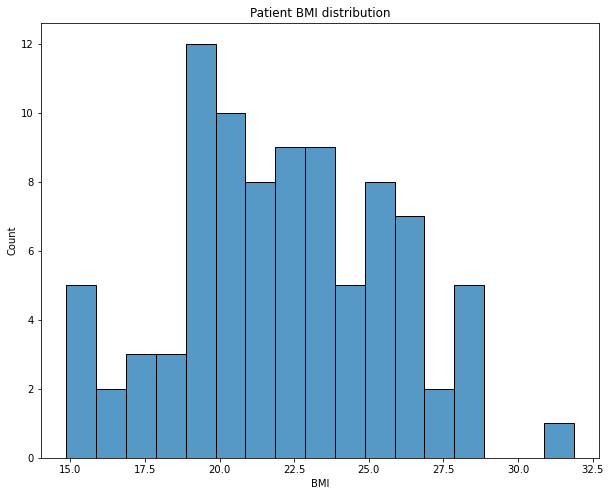

In [54]:
bmi_info['BMI']
df = pd.DataFrame({'sample':bmi_info.index,'BMI':bmi_info['BMI'],'Overweight':bmi_info['Overweight']})
plt.figure(figsize=(10,8))
sns.histplot(data =df,x='BMI',palette='pastel',binwidth=1)
plt.title('Patient BMI distribution')
output_path = "/home/bruce1996/data/Yi-Fung-Chuang/obesity/"
#plt.savefig(output_path+'bmi_distribution.png',dpi = 300)

## feature selection

In [12]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### domain knowledge base

In [55]:
obesity_associated_g = ['Bacillus','Bacteroides','Escherichia','Fusobacterium','Lactobacillus']
obesity_associated_s = ['Eubacterium rectale','Lactobacillus reuteri','Roseburia intestinalis']
def is_obesity_associated(x) :
    flag = False
    if x in obesity_associated_s :
        flag = True
    elif x.split(' ')[0] in obesity_associated_g :
        flag = True
    return flag

In [56]:
idx = [is_obesity_associated(x) for x in bmi_otu.columns]
obesity_df = bmi_otu.loc[:,idx]
idx = [x != 0 for x in obesity_df.sum(axis=0)]
obesity_df = obesity_df.loc[:,idx]

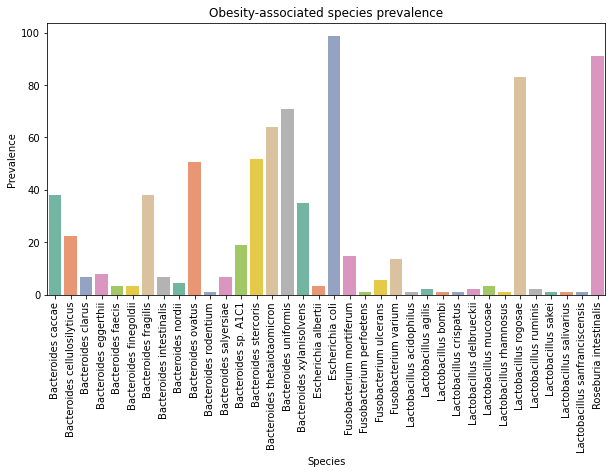

In [60]:
p = taxa_prevalence(obesity_df.T)
s = obesity_df.columns
prevalence_df = pd.DataFrame({'Species':s,'Prevalence':p})
plt.figure(figsize=(10,5))
sns.barplot(data=prevalence_df,x='Species',y='Prevalence',palette='Set2')
plt.xticks(rotation=90)
plt.title('Obesity-associated species prevalence')
plt.savefig(output_path + 'ob-associated-species-prevalence.png',dpi = 300)

### filter base method

In [105]:
#filter by mutual inforamtion coefficient
from minepy import MINE

#encode overweight label from string to binary integer
y = np.zeros(bmi_otu.shape[0])
for i,x in enumerate(bmi_info['Overweight'].values) :
    if x == 'Overweight' :
        y[i] = 1

mic_array = np.zeros(bmi_otu.shape[1])
for i in range(bmi_otu.shape[1]) :
    m = MINE()
    m.compute_score(bmi_otu.iloc[:,i],y)
    mic_array[i] = m.mic()

df = pd.DataFrame({'Feature' : bmi_otu.columns,'MIC': mic_array})
df = df.sort_values(by='MIC',ascending=False)
f = df['Feature'][:50]
bmi_otu_subset_mic = bmi_otu.loc[:,f]

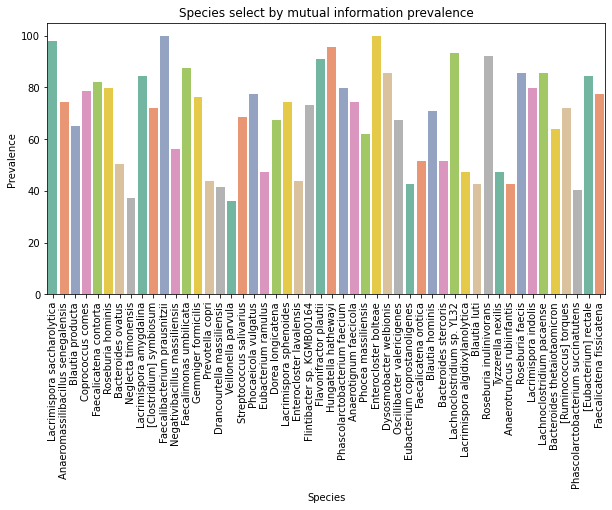

In [106]:
p = taxa_prevalence(bmi_otu_subset_mic.T)
s = bmi_otu_subset_mic.columns
prevalence_df = pd.DataFrame({'Species':s,'Prevalence':p})
plt.figure(figsize=(10,5))
sns.barplot(data=prevalence_df,x='Species',y='Prevalence',palette='Set2')
plt.xticks(rotation=90)
plt.title('Species select by mutual information prevalence')
plt.savefig(output_path + 'Mutual-information-select-feature-prevalence.png',dpi = 300)

### wrapper method (Recrusive feature elinmination)

In [104]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel='linear')
selector = RFE(estimator=estimator,n_features_to_select=50)
selector.fit(bmi_otu,y)
idx = selector.support_
bmi_otu_subset_rfe = bmi_otu.loc[:,idx]

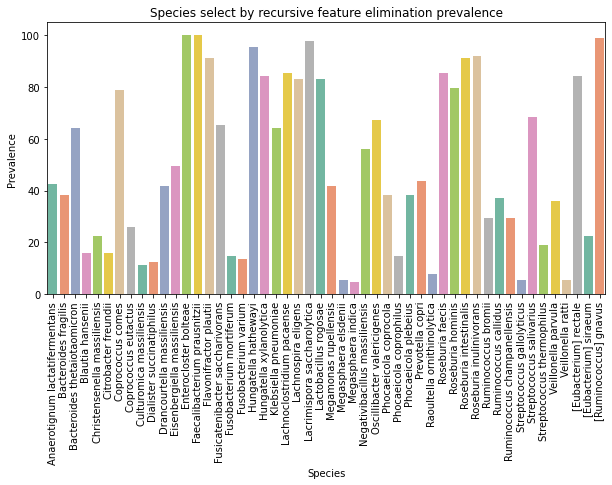

In [107]:
p = taxa_prevalence(bmi_otu_subset_rfe.T)
s = bmi_otu_subset_rfe.columns
prevalence_df = pd.DataFrame({'Species':s,'Prevalence':p})
plt.figure(figsize=(10,5))
sns.barplot(data=prevalence_df,x='Species',y='Prevalence',palette='Set2')
plt.xticks(rotation=90)
plt.title('Species select by recursive feature elimination prevalence')
plt.savefig(output_path + 'recursive-feature-elimination-species-prevalence.png',dpi = 300)

### embedded method

In [109]:
import sklearn
from sklearn import metrics
import scipy.io as sio
import math
import sys
sys.path.append('/home/bruce1996/tools/JMLR2018/python/')
import stability as st

def getMutualInfos(data,labels):
    '''
    This function takes as input the data and labels and returns the mutual information of each feature 
    with the labels in a np.dnarray of length d
    
    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data
    
    OUPUT:
    - a 1-dimensional numpy.ndarray of length d (where d is the number of features) 
      with the mutual information of each feature with the label
    '''
    M,d=data.shape
    mutualInfos=np.zeros(d)
    # for each feature
    for f in range(d):
        # we calculate the mutual information of the feature with the labels
        mutualInfos[f]=metrics.mutual_info_score(data[:,f],labels)
    return mutualInfos


def getBootstrapSample(data,labels):
    '''
    This function takes as input the data and labels and returns 
    a bootstrap sample of the data, as well as its out-of-bag (OOB) data
    
    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data
    
    OUPUT:
    - a dictionnary where:
          - key 'bootData' gives a 2-dimensional numpy.ndarray which is a bootstrap sample of data
          - key 'bootLabels' is a 1-dimansional numpy.ndarray giving the label of each example in bootData
          - key 'OOBData' gives a 2-dimensional numpy.ndarray the OOB examples
          - key 'OOBLabels' is a 1-dimansional numpy.ndarray giving the label of each example in OOBData
    '''
    m,d=data.shape
    if m!= len(labels):
        raise ValueError('The data and labels should have a same number of rows.')
    ind=np.random.choice(range(m), size=m, replace=True)
    OOBind=np.setdiff1d(range(m),ind, assume_unique=True)
    bootData=data[ind,]
    bootLabels=labels[ind]
    OOBData=data[OOBind,]
    OOBLabels=labels[OOBind]
    return {'bootData':bootData,'bootLabels':bootLabels,'OOBData':OOBData,'OOBLabels':OOBLabels}

def generateAtificialDataset(m,d,d_rel,rho):
    ''' This function enerates the artificial dataset used in the experiments (Section 7.1) of [1].
        The data set is made of continuous data where the first
        d_rel featues are relevant and where the d-d_rel remaining features are irrelevant to the target class
        this is a balanced data set where m/2 examples belong to class -1 and m/2 to class 1
        
        INPUTS:
        m is the number of samples
        d is the number of features/variables
        d_rel is the number of relevant features
        rho is the degree of redundancy (should be between 0 and 1)
        
        OUPUTS:
        A dictionnary with the data and the labels
    '''
    if d_rel>=d:
        raise ValueError('The input number of relevant features d_rel must be strictly less than the total number of features d')
    if rho<0 or rho >1:
        raise ValueError('The input argument rho controlling the degree of redundancy between the relevant features must be a value between 0 and 1.');
    num_positives=int(m/2) ## Take half instances as positive examples
    num_negatives=m-num_positives
    labels=np.concatenate((np.ones((num_positives),dtype=np.int8),-np.ones((num_negatives),dtype=np.int8)))
    mu_plus=np.concatenate((np.ones((d_rel),dtype=np.int8),np.zeros((d-d_rel)))) ## mean of the positive examples
    mu_minus=np.concatenate((-np.ones((d_rel),dtype=np.int8),np.zeros(d-d_rel)))  ## mean of the negative examples
    Sigma_star=rho*np.ones((d_rel,d_rel),dtype=np.int8)+(1-rho)*np.eye(d_rel)
    sub1=np.concatenate((Sigma_star,np.zeros((d_rel,d-d_rel))))
    sub2=np.concatenate((np.zeros((d-d_rel,d_rel)),np.eye(d-d_rel)))
    Sigma=np.concatenate((sub1,sub2),axis=1) ## the covariance matrix
    positive_ex=np.random.multivariate_normal(mu_plus, Sigma,num_positives)
    negative_ex=np.random.multivariate_normal(mu_minus, Sigma,num_negatives)
    data=np.concatenate((positive_ex,negative_ex),axis=0)
    ## we randomly permute the examples...
    order=ind=np.random.choice(range(m), size=m, replace=False)
    data=data[order,]
    labels=labels[order]
    trueRelevantSet=np.zeros(d)
    trueRelevantSet[range(d_rel)]=1
    return {'data':data,'labels':labels,'trueRelevantSet':trueRelevantSet}


In [119]:
cs = np.arange(50,200,5)
n_c = len(cs)
n_run = 100
n_feature = bmi_otu.shape[1]
nfeature_array = np.zeros((n_c,n_run))
Z = np.zeros((n_c,n_run,n_feature),dtype=np.int8)
stabilities=np.zeros(n_c)
errStab=np.zeros(n_c)

for c in range(len(cs)) :
    for r in range(n_run) :

        x_train, x_test, y_train, y_test = train_test_split(bmi_otu, bmi_info['Overweight'].values, test_size=0.20)
        fit = LogisticRegression(C = cs[c],penalty = 'l1',solver = 'liblinear').fit(x_train,y_train)
        Z[c,r,:]=sum(fit.coef_!=0)
        nfeature_array[c,r] = sum(sum(fit.coef_!=0))

    res=st.confidenceIntervals(Z[c,:,:],alpha=0.05)
    stabilities[c]=res['stability']
    errStab[c]=stabilities[c]-res['lower']
    '''
    print('C is : {c},Feature number : {n_feature},Stability : {Stab}'.format(c = cs[c],
            n_feature = np.mean(nfeature_array[c,:]),
            Stab = stabilities[c] ))
    '''

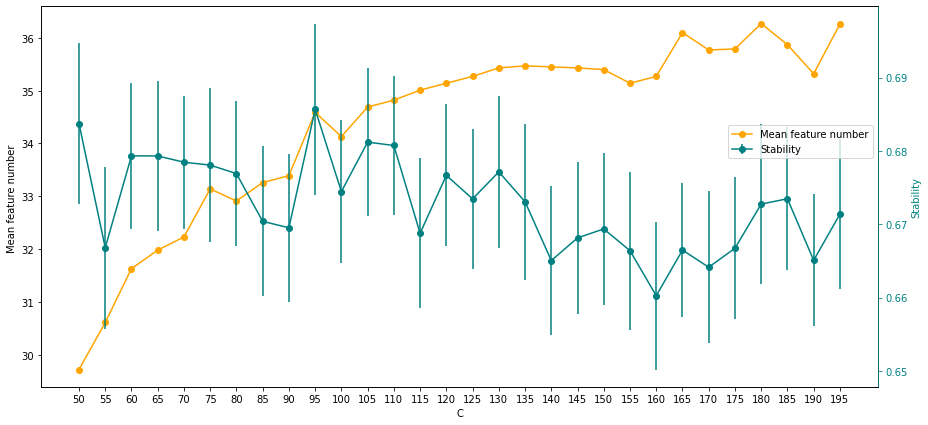

In [120]:
import seaborn as sns
mean_feature_number = []
for i in range(len(cs)):
    mean_feature_number.append(np.mean(nfeature_array[i,:]))
    
fig, ax1 = plt.subplots(figsize = (15,7))
ax2 = ax1.twinx()
ln1 = ax1.errorbar(cs,mean_feature_number, fmt='-o',c = 'orange',label = "Mean feature number")
ln2 = ax2.errorbar(cs,stabilities,yerr=errStab,fmt='-o',c='teal',label = "Stability")
ax1.set_ylabel('Mean feature number ')
ax2.tick_params(colors='teal', which='both')
ax2.set_ylabel('Stability',color = "teal")
ax2.spines['right'].set_color('teal')
ax1.set_xlabel('C')
ax1.set_xticks(cs)
fig.legend(loc="upper right",bbox_to_anchor=(1,0.7), bbox_transform=ax1.transAxes)
#plt.savefig('tmp/test.png',dpi = 300)
plt.show()

In [123]:
c_idx = np.where(stabilities == stabilities.max())
fit = LogisticRegression(C = cs[c_idx][0],penalty = 'l1',solver = 'liblinear').fit(bmi_otu, bmi_info['Overweight'].values)
subset_idx = fit.coef_ != 0
bmi_otu_subset_lasso = bmi_otu.loc[:,list(subset_idx[0])]

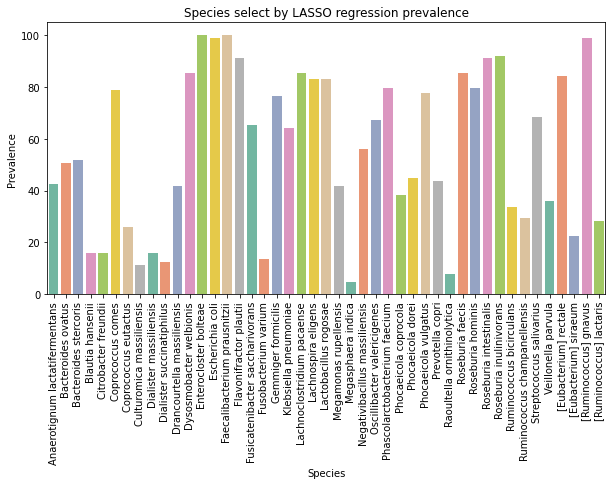

In [124]:
p = taxa_prevalence(bmi_otu_subset_lasso.T)
s = bmi_otu_subset_lasso.columns
prevalence_df = pd.DataFrame({'Species':s,'Prevalence':p})
plt.figure(figsize=(10,5))
sns.barplot(data=prevalence_df,x='Species',y='Prevalence',palette='Set2')
plt.xticks(rotation=90)
plt.title('Species select by LASSO regression prevalence')
plt.savefig(output_path + 'lasso-species-prevalence.png',dpi = 300)

## Linear regression

In [125]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

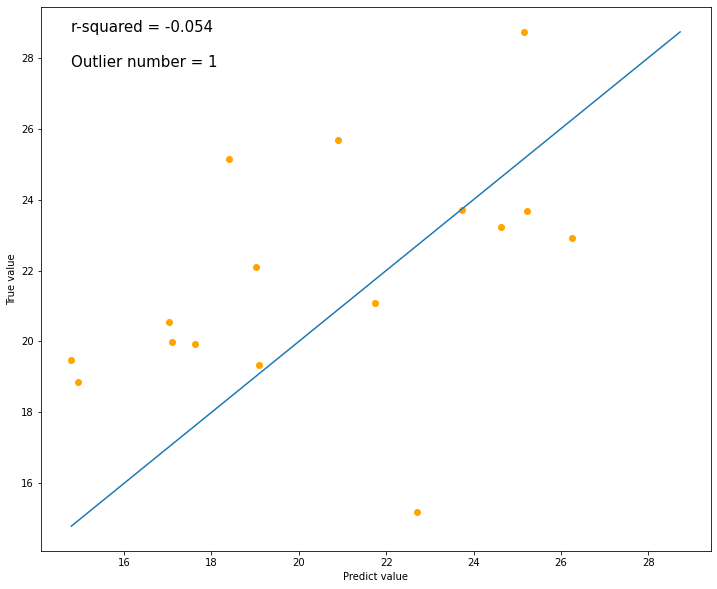

In [131]:
model = LinearRegression(fit_intercept=True)
x_train, x_test, y_train, y_test = train_test_split(bmi_otu_subset_rfe, bmi_info['BMI'].values, test_size=0.20)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
y_true = y_test
#remove outlier
diff = abs(y_pred - y_true)
y_pred = y_pred[np.where(diff < 10)]
y_true = y_true[np.where(diff < 10)]
n_outlier = len(np.where(diff > 10))

#y_true = bmi_info['BMI'].values
max_x = max(y_pred.max(),y_true.max())
min_x = min(y_pred.min(),y_true.min())
r2 = r2_score(y_pred,y_true)

plt.figure(figsize=(12,10))
plt.scatter(y_pred,y_true,color = 'orange')
line = np.linspace(min_x,max_x)
plt.plot(line,line)
plt.annotate("r-squared = {:.3f}".format(r2),(min_x,max_x),fontsize = 15)
plt.annotate("Outlier number = {:d}".format(n_outlier),(min_x,max_x-1),fontsize = 15)
plt.xlabel('Predict value')
plt.ylabel('True value')
#plt.savefig('tmp/linear_regression.png',dpi = 300)
plt.show()


## Logistic regression

In [132]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

<ErrorbarContainer object of 3 artists>

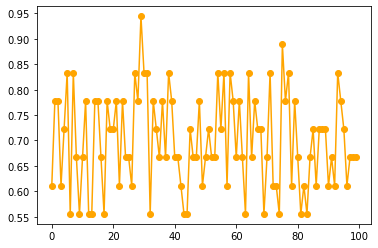

In [135]:
data = bmi_otu_subset_rfe
acc = []
for i in range(100) :
    x_train, x_test, y_train, y_test = train_test_split(data, bmi_info['Overweight'].values, test_size=0.2)
    fit = LogisticRegression().fit(x_train,y_train)
    y_pred = fit.predict(x_test)
    acc.append(accuracy_score(y_test,y_pred))
plt.errorbar(np.arange(100),acc,fmt='o-',color = 'orange')